# Imports

In [1]:
!pip uninstall -y gensim
!pip install gensim==4.1.2
!pip install torchdata
!pip install flair
!pip install nlpaug
!pip install sacremoses

!pip install gdown==4.4
!gdown https://drive.google.com/uc?id=1v4JA7gvNWoLT1Kxj-1D0JtOXCOOanldJ
!mv '/content/GoogleNews-vectors-negative300 (1).bin.gz' /content/GoogleNews-vectors-negative300.bin.gz
!gzip -fqd /content/GoogleNews-vectors-negative300.bin.gz

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 24.1 MB 37.0 MB/s 
     |████████████████████████████████| 47 kB 2.4 MB/s 
     |████████████████████████████████| 138 kB 9.9 MB/s 
     |████████████████████████████████| 127 kB 36.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 402 kB 5.2 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 981 kB 44.1 MB/s 
     |████████████████████████████████| 1.2 MB 35.0 MB/s 
  Inst

In [2]:
!git clone https://github.com/bogdankjastrzebski/NLP-2022L.git

Cloning into 'NLP-2022L'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 316 (delta 34), reused 12 (delta 12), pack-reused 253
Receiving objects: 100% (316/316), 15.11 MiB | 22.66 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [3]:
!mv /content/NLP-2022L/projects/team_5/ms_2/src/* .

In [4]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cpu')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2022-05-16 18:44:29,691 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpo1yxtqks


100%|██████████| 160000128/160000128 [00:08<00:00, 19839981.42B/s]

2022-05-16 18:44:38,142 copying /tmp/tmpo1yxtqks to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2022-05-16 18:44:38,525 removing temp file /tmp/tmpo1yxtqks
2022-05-16 18:44:38,964 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmp9pijxs8m


100%|██████████| 21494764/21494764 [00:01<00:00, 11374343.87B/s]

2022-05-16 18:44:41,267 copying /tmp/tmp9pijxs8m to cache at /root/.flair/embeddings/glove.gensim
2022-05-16 18:44:41,301 removing temp file /tmp/tmp9pijxs8m


# 2. VAE

## 2.1 Loading Data

In [5]:
ds = AG_NEWS_preparation()
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

Preparing sentences...


100%|██████████| 120000/120000 [04:31<00:00, 441.32it/s]


Making sentences...


100%|██████████| 120000/120000 [01:38<00:00, 1219.94it/s]


Embedding sentences...


100%|██████████| 120000/120000 [00:46<00:00, 2567.80it/s]


Splitting sentences...


100%|██████████| 120000/120000 [00:05<00:00, 22264.05it/s]

Done!


In [19]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

In [8]:
import gc
n = gc.collect()

## 2.2 Training loop

In [41]:
m = Autoencoder(100,100,100,4,3,variational=True,max_log2len=8)
Ls = []
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [42]:
Ls = []
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []

In [43]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [44]:
EPOCHS = 5
beta = 0.1
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    pbar = tqdm(dl_train)
    m = m.train()
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx, (mu, logvar) = m(x_in, return_Z=True)
        Lmse = (mx - x_out).pow(2).sum((1,2)).mean()
        Lvar = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum((1,2)).mean()
        L = Lmse + beta*Lvar
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()} Lmse: {Lmse.item()} Lvar: {Lvar.item()}")
        
        Lsmse.append(Lmse.item())
        Lsvar.append(Lvar.item())
        Ls.append(L.item())
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

    torch.save(({'train': Ls_train, 'valid':Ls, 'mse': Lmse, 'var': Lvar}, m.state_dict()), f'/content/drive/MyDrive/learning-nlp/model_epoch_{e}')


Epoch: 0


L: 261.8377990722656 Lmse: 258.5765075683594 Lvar: 32.612850189208984: 100%|██████████| 9350/9350 [08:52<00:00, 17.56it/s]
VL: 275.34295654296875: 100%|██████████| 32/32 [00:00<00:00, 49.39it/s]


Epoch: 1


L: 233.61106872558594 Lmse: 229.60435485839844 Lvar: 40.06711959838867: 100%|██████████| 9350/9350 [08:53<00:00, 17.53it/s]
VL: 248.32757568359375: 100%|██████████| 32/32 [00:00<00:00, 48.86it/s]


Epoch: 2


L: 244.36984252929688 Lmse: 240.6240692138672 Lvar: 37.457664489746094: 100%|██████████| 9350/9350 [08:54<00:00, 17.50it/s]
VL: 189.89959716796875: 100%|██████████| 32/32 [00:00<00:00, 49.26it/s]


Epoch: 3


L: 259.88800048828125 Lmse: 255.7718505859375 Lvar: 41.16154479980469: 100%|██████████| 9350/9350 [09:04<00:00, 17.16it/s]
VL: 234.25961303710938: 100%|██████████| 32/32 [00:00<00:00, 42.39it/s]


Epoch: 4


L: 222.90731811523438 Lmse: 218.91351318359375 Lvar: 39.93803024291992: 100%|██████████| 9350/9350 [09:02<00:00, 17.23it/s]
VL: 204.06121826171875: 100%|██████████| 32/32 [00:00<00:00, 46.31it/s]


In [49]:
EPOCHS = 5
beta = 0.1
offset = 5
for e in range(EPOCHS):
    e += offset
    print(f"Epoch: {e}")
    pbar = tqdm(dl_train)
    m = m.train()
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx, (mu, logvar) = m(x_in, return_Z=True)
        Lmse = (mx - x_out).pow(2).sum((1,2)).mean()
        Lvar = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum((1,2)).mean()
        L = Lmse + beta*Lvar
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()} Lmse: {Lmse.item()} Lvar: {Lvar.item()}")
        
        Lsmse.append(Lmse.item())
        Lsvar.append(Lvar.item())
        Ls_train.append(L.item())
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

torch.save(({'train': Ls_train, 'valid':Ls_valid, 'mse': Lsmse, 'var': Lsvar}, m.state_dict()), f'/content/drive/MyDrive/learning-nlp/model_epoch_{e}')


Epoch: 5


L: 228.16136169433594 Lmse: 223.70703125 Lvar: 44.54328918457031: 100%|██████████| 9350/9350 [08:55<00:00, 17.48it/s]
VL: 193.4586639404297: 100%|██████████| 32/32 [00:00<00:00, 50.13it/s]


Epoch: 6


L: 269.96282958984375 Lmse: 265.6165771484375 Lvar: 43.46245193481445: 100%|██████████| 9350/9350 [08:43<00:00, 17.85it/s]
VL: 228.5794677734375: 100%|██████████| 32/32 [00:00<00:00, 50.23it/s]


Epoch: 7


L: 252.36856079101562 Lmse: 247.0518798828125 Lvar: 53.1668701171875: 100%|██████████| 9350/9350 [08:39<00:00, 18.01it/s]
VL: 205.23812866210938: 100%|██████████| 32/32 [00:00<00:00, 49.09it/s]


Epoch: 8


L: 230.2249755859375 Lmse: 224.9503173828125 Lvar: 52.74650955200195: 100%|██████████| 9350/9350 [08:39<00:00, 17.99it/s]
VL: 211.8352813720703: 100%|██████████| 32/32 [00:00<00:00, 50.79it/s]


Epoch: 9


L: 247.95318603515625 Lmse: 242.24844360351562 Lvar: 57.04736328125: 100%|██████████| 9350/9350 [08:39<00:00, 18.00it/s]
VL: 237.44610595703125: 100%|██████████| 32/32 [00:00<00:00, 45.27it/s]


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


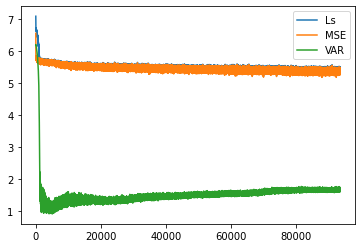

In [53]:
plt.plot(np.log(Ls_train), label="Ls")
plt.plot(np.log(Lsmse), label="MSE")
plt.plot(np.log(beta*np.array(Lsvar)), label="VAR")
plt.legend()

For AG_NEWS dataset, the training curves look similar to the ones described in the IMDB section. The overall loss is mostly comprised of the MSE loss. The variational loss is much lower in comparison. The overall loss is being minimised very slowly. 

The validation loss matches the MSE (batch losses concatenated):

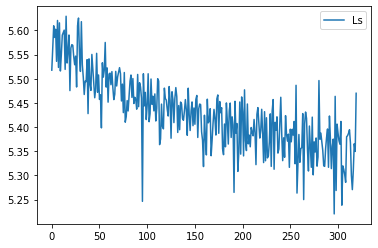

In [52]:
plt.plot(np.log(Ls_valid), label="Ls")
plt.legend()